In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pymc3 as pm
import pandas
import statsmodels.api as sm
import theano
from patsy import contrasts

/Users/richardweiss/.pyenv/versions/3.6.0/envs/blackstone-reporting/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
np.random.seed(804188826)
n = 1000
a = np.random.choice(10, size=n)
a_value = np.random.normal(size=10)
b = np.random.normal(size=n)
b_coeff = np.random.normal(0, 5)
intercept = np.random.normal() + 10

y_underlying = a_value[a] + b*b_coeff + intercept
y = y_underlying + np.random.normal(size=n)

data_mat = pandas.DataFrame({
    'a': a,
    'b': b,
    'y': y,
})

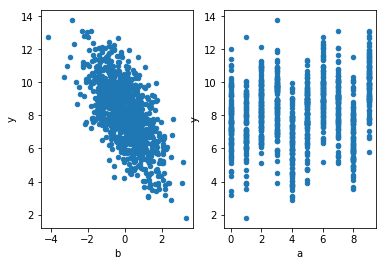

In [4]:
_, axs = plt.subplots(ncols=2)
data_mat.plot.scatter('b', 'y', ax=axs[0])
data_mat.plot.scatter('a', 'y', ax=axs[1])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,484.1: 100%|██████████| 200000/200000 [00:25<00:00, 7914.82it/s]
Finished [100%]: Average ELBO = -1,484
100%|██████████| 1000/1000 [00:27<00:00, 36.02it/s]


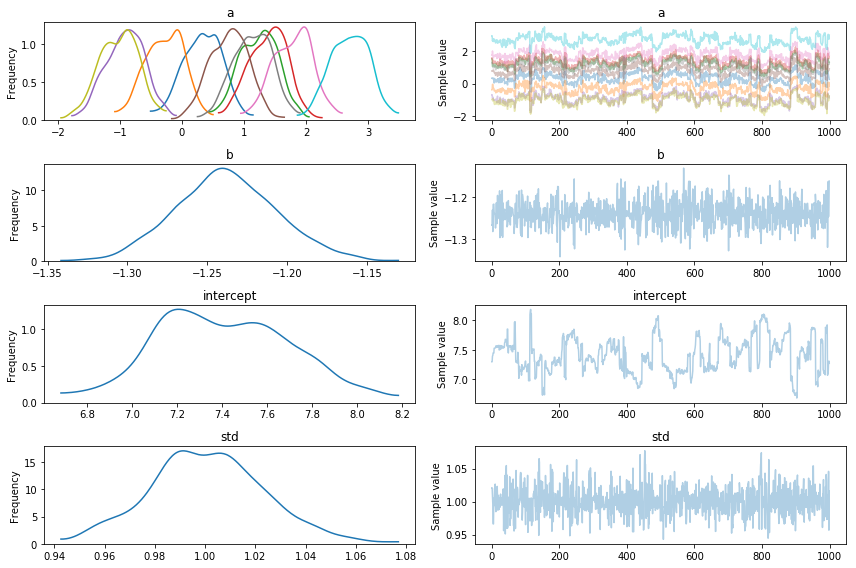

In [5]:
# Wandering example
with pm.Model() as model:
    a_coeff = pm.Normal('a', shape=10)
    b_coeff = pm.Normal('b')
    intercept = pm.Normal('intercept')
    sd = pm.HalfNormal('std')
    
    mu = (a_coeff[data_mat.a.values] + 
          data_mat.b.values * b_coeff +
          intercept)
    pm.Normal('obs', mu=mu, sd=sd, observed=data_mat.y.values)
    
    trace = pm.sample(1000)
    pm.traceplot(trace)
    plt.savefig('./wandering-coefficients/wandering.png')
    ppc = pm.sample_ppc(trace)

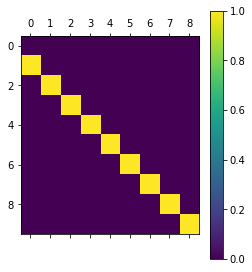

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,482.3: 100%|██████████| 200000/200000 [00:30<00:00, 6640.64it/s]
Finished [100%]: Average ELBO = -1,482.3
100%|██████████| 1000/1000 [00:27<00:00, 36.07it/s]


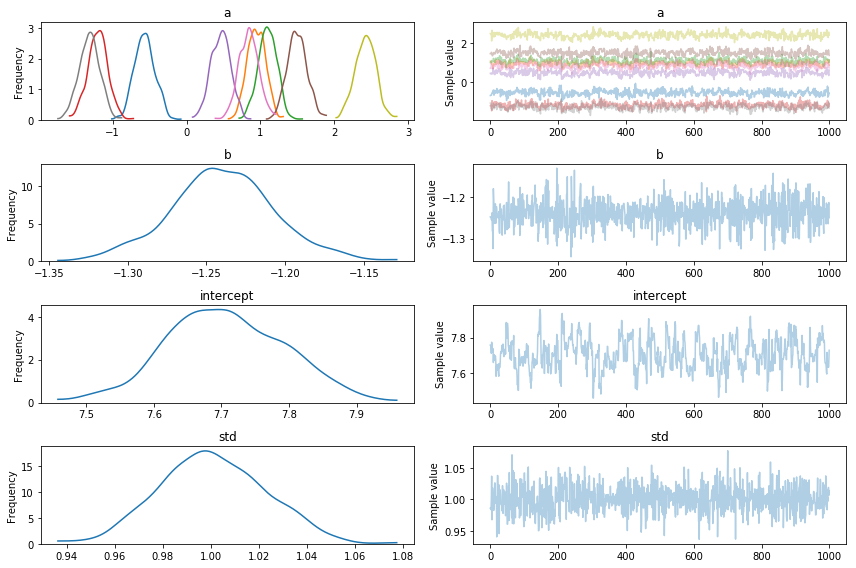

In [6]:
cs = contrasts.Treatment().code_without_intercept(list(range(10)))
matshow(cs.matrix)
colorbar()
plt.savefig('./wandering-coefficients/treatment_coding.png')
plt.show()
plt.close()
with pm.Model() as model:
    a_coeff = pm.Normal('a', shape=cs.matrix.shape[1])
    b_coeff = pm.Normal('b')
    intercept = pm.Normal('intercept')
    sd = pm.HalfNormal('std')
    
    mu = (theano.dot(cs.matrix[data_mat.a.values], a_coeff) + 
          b_coeff * data_mat.b.values +
          intercept)
    pm.Normal('obs', mu=mu, sd=sd, observed=data_mat.y.values)
    
    trace_trt = pm.sample(1000)
    pm.traceplot(trace_trt)
    plt.savefig('./wandering-coefficients/treatment_trace.png')
    ppc = pm.sample_ppc(trace_trt)

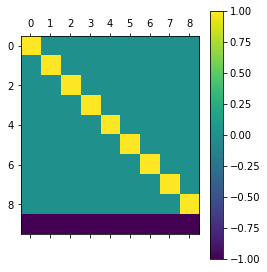

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,485.6: 100%|██████████| 200000/200000 [00:32<00:00, 6099.82it/s]
Finished [100%]: Average ELBO = -1,485.7
100%|██████████| 1000/1000 [00:26<00:00, 38.27it/s]


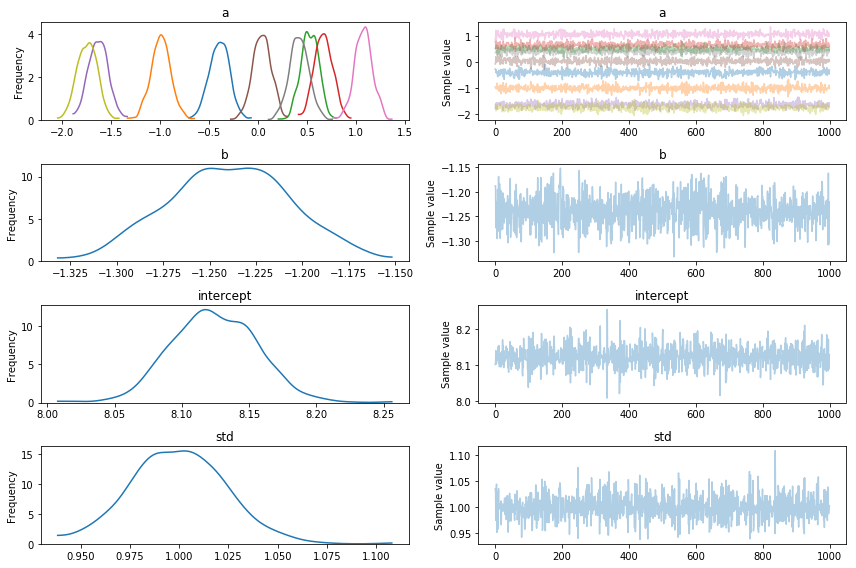

In [7]:
cs = contrasts.Sum().code_without_intercept(list(range(10)))
matshow(cs.matrix)
colorbar()
plt.savefig('./wandering-coefficients/sum_coding.png')
plt.show()
plt.close()
with pm.Model() as model:
    a_coeff = pm.Normal('a', shape=cs.matrix.shape[1])
    b_coeff = pm.Normal('b')
    intercept = pm.Normal('intercept')
    sd = pm.HalfNormal('std')
    
    mu = (theano.dot(cs.matrix[data_mat.a.values], a_coeff) + 
          b_coeff * data_mat.b.values +
          intercept)
    pm.Normal('obs', mu=mu, sd=sd, observed=data_mat.y.values)

    trace_sum = pm.sample(1000)
    pm.traceplot(trace_sum)
    plt.savefig('./wandering-coefficients/sum_trace.png')
    ppc = pm.sample_ppc(trace_sum)

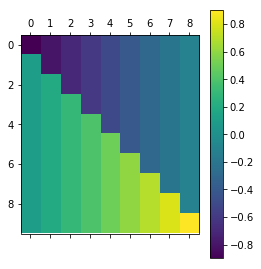

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,495.7: 100%|██████████| 200000/200000 [00:31<00:00, 6416.16it/s]
Finished [100%]: Average ELBO = -1,495.8
100%|██████████| 1000/1000 [00:27<00:00, 36.97it/s]


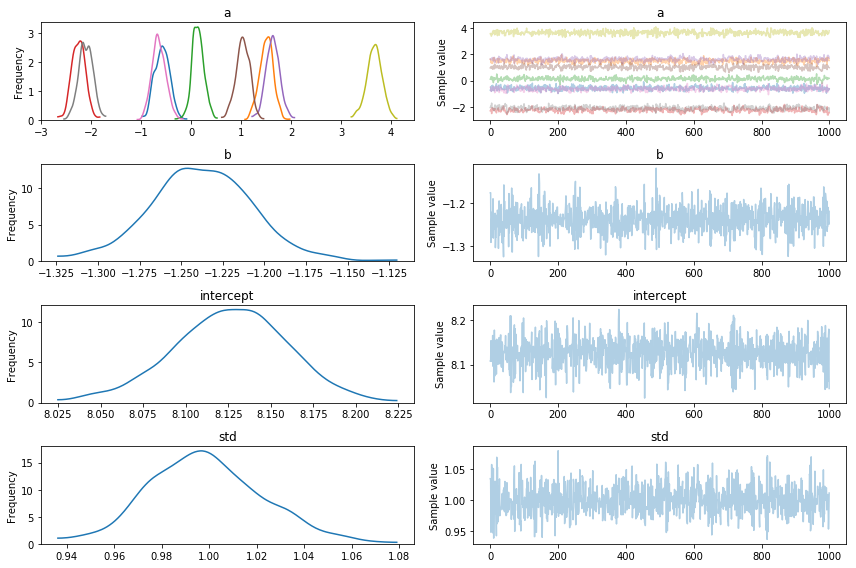

In [8]:
cs = contrasts.Diff().code_without_intercept(list(range(10)))
matshow(cs.matrix)
colorbar()
plt.savefig('./wandering-coefficients/diff_coding.png')
plt.show()
plt.close()
with pm.Model() as model:
    a_coeff = pm.Normal('a', shape=cs.matrix.shape[1])
    b_coeff = pm.Normal('b')
    intercept = pm.Normal('intercept')
    sd = pm.HalfNormal('std')
    
    mu = (theano.dot(cs.matrix[data_mat.a.values], a_coeff) + 
          b_coeff * data_mat.b.values +
          intercept)
    pm.Normal('obs', mu=mu, sd=sd, observed=data_mat.y.values)

    trace_diff = pm.sample(1000)
    pm.traceplot(trace_diff)
    plt.savefig('./wandering-coefficients/diff_trace.png')
    ppc = pm.sample_ppc(trace_diff)

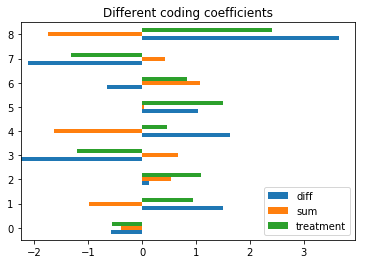

In [9]:
dd = pandas.DataFrame({
    'sum': trace_sum['a'].mean(0),
    'treatment': trace_trt['a'].mean(0),
    'diff': trace_diff['a'].mean(0)
})
dd.plot.barh()
plt.title('Different coding coefficients')
plt.savefig('wandering-coefficients/coeffs.png')

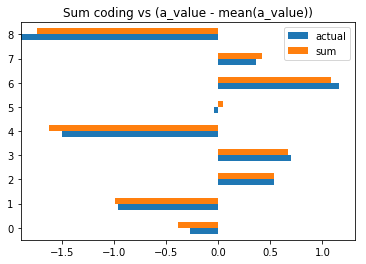

In [10]:
pandas.DataFrame({
    'sum': trace_sum['a'].mean(0),
    'actual': (a_value-mean(a_value))[:-1]
}).plot.barh()
plt.title('Sum coding vs (a_value - mean(a_value))')
plt.savefig('wandering-coefficients/sum_coeffs.png')

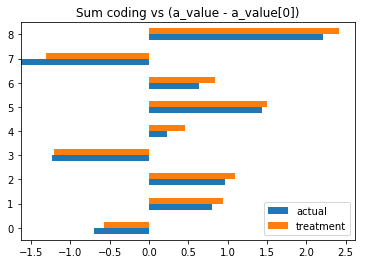

In [11]:
pandas.DataFrame({
    'treatment': trace_trt['a'].mean(0),
    'actual': (a_value-a_value[0])[1:]
}).plot.barh()
plt.title('Sum coding vs (a_value - a_value[0])')
plt.savefig('wandering-coefficients/treatment_coeffs.png')

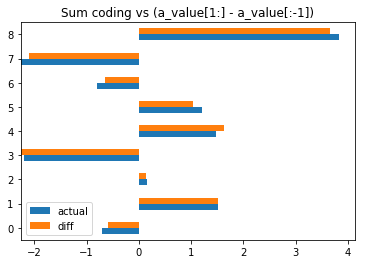

In [12]:
pandas.DataFrame({
    'diff': trace_diff['a'].mean(0),
    'actual': a_value[1:] - a_value[:-1]
}).plot.barh()
plt.title('Sum coding vs (a_value[1:] - a_value[:-1])')
plt.savefig('wandering-coefficients/diff_coeffs.png')